# Step 1A: Raw data exploration

This notebook can be run after executing the `1_data_ingestion` notebook. This notebook examines the SPARK data frames constructed in the previous notebook. Much of the text from the `1_data_ingestion` notebook has been repeated here for convenience.

## Data source

The common data elements for predictive maintenance problems can be summarized as follows:

* Machine features: The features specific to each individual machine, e.g. engine size, make, model, location, installation date.
* Telemetry data: The operating condition data collected from sensors, e.g. temperature, vibration, operating speeds, pressures.
* Maintenance history: The repair history of a machine, e.g. maintenance activities or component replacements, this can also include error code or runtime message logs.
* Failure history: The failure history of a machine or component of interest.

It is possible that failure history is contained within maintenance history, either as in the form of special error codes or order dates for spare parts. In those cases, failures can be extracted from the maintenance data. Additionally, different business domains may have a variety of other data sources that influence failure patterns which are not listed here exhaustively. These should be identified by consulting the domain experts when building predictive models.

Some examples of above data elements from use cases are:
    
**Machine conditions and usage:** Flight routes and times, sensor data collected from aircraft engines, sensor readings from ATM transactions, train events data, sensor readings from wind turbines, elevators and connected cars.
    
**Machine features:** Circuit breaker technical specifications such as voltage levels, geolocation or car features such as make, model, engine size, tire types, production facility etc.

**Failure history:** fight delay dates, aircraft component failure dates and types, ATM cash withdrawal transaction failures, train/elevator door failures, brake disk replacement order dates, wind turbine failure dates and circuit breaker command failures.

**Maintenance history:** Flight error logs, ATM transaction error logs, train maintenance records including maintenance type, short description etc. and circuit breaker maintenance records.

Given the above data sources, the two main data types we observe in predictive maintenance domain are temporal data and static data. Failure history, machine conditions, repair history, usage history are time series indicated by the timestamp of data collection. Machine and operator specific features, are more static, since they usually describe the technical specifications of machines or operator’s properties.

For this scenario, we use relatively large-scale data to walk the user through the main steps from data ingestion, feature engineering, model building, and model operationalization and deployment. The code for the entire process is written in PySpark and implemented using Jupyter notebooks.

# Step 1A: Data exploration.

We do some preliminary data cleaning and verification, and generate some data exploration figures to help understand the data we will be working with in the remainder of this scenario.

**Note:** This notebook will take about 2-3 minutes to execute all cells, depending on the compute configuration you have setup.

In [2]:
## Setup our environment by importing required libraries
# For creating some preliminary EDA plots.
# %matplotlib inline
import matplotlib.pyplot as plt

# Read csv file from URL directly
import pandas as pd
from ggplot import *
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

# These file names detail which blob each files is stored under. 
MACH_DATA = 'machines_data'
MAINT_DATA = 'maint_data'
ERROR_DATA = 'errors_data'
TELEMETRY_DATA = 'telemetry_data'
FAILURE_DATA = 'failure_data'

## Load simulated data sets
We downloaded the simulated data files in the `.\notebooks\1_data_ingestion` notebook and stored the data as SPARK data frames in the five data sets:

 * machines_files
 * maint_files
 * errors_files
 * telemetry_files
 * failures_files

There are 1000 machines of four different models. Each machine contains four components of interest, and four sensors measuring voltage, pressure, vibration and rotation. A controller monitors the system and raises alerts for five different error conditions. Maintenance logs indicate when something is done to the machine which does not include a component replacement. A failure is defined by the replacement of a component. 

![Machine Schemaic](https://raw.githubusercontent.com/Azure/BatchSparkScoringPredictiveMaintenance/master/images/machine.png)

This notebook does some preliminary data cleanup and creates summary graphics for each data set to verify the data downloaded correctly

### Machines data set

This simulation tracks a simulated set of 1000 machines over the course of a single year (2015). 

This data set includes information about each machine: Machine ID, model type and age (years in service).

The following figure plots a histogram of the machines age colored by the specific model.

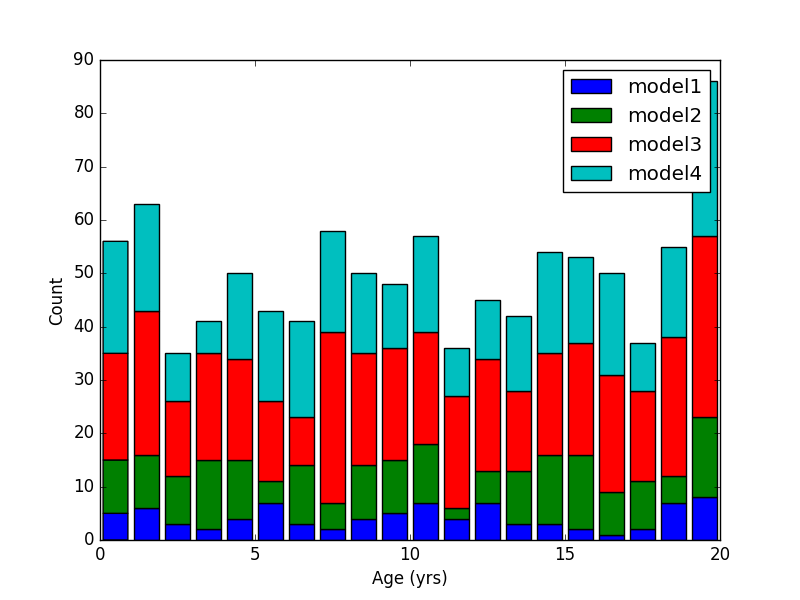

In [5]:
mach = spark.table(MACH_DATA) # spark.sql("SELECT * FROM " + MACH_DATA)

machines = mach.toPandas()
# one hot encoding of the variable model, basically creates a set of dummy boolean variablesplt.figure(figsize=(8, 6))

fig, ax = plt.subplots()

_, bins, _ = plt.hist([machines.loc[machines['model'] == 'model1', 'age'],
                       machines.loc[machines['model'] == 'model2', 'age'],
                       machines.loc[machines['model'] == 'model3', 'age'],
                       machines.loc[machines['model'] == 'model4', 'age']],
                       20, stacked=True, 
                      label=['model1', 'model2', 'model3', 'model4'])

plt.xlabel('Age (yrs)')
plt.ylabel('Count')
plt.legend()
display(fig)

The figure shows how long the collection of machines have been in service. It indicates there are four model types, shown in different colors, and all four models have been in service over the entire 20 years of service. The machine age will be a feature in our analysis, since we expect older machines may have a different set of errors and failures then machines that have not been in service long.

### Errors  data set

The error log contains non-breaking errors recorded while the machine is still operational. These errors are not considered failures, though they may be predictive of a future failure event. The error datetime field is rounded to the closest hour since the telemetry data (loaded later) is collected on an hourly rate.

The following histogram details the distribution of the errors tracked in the log files.

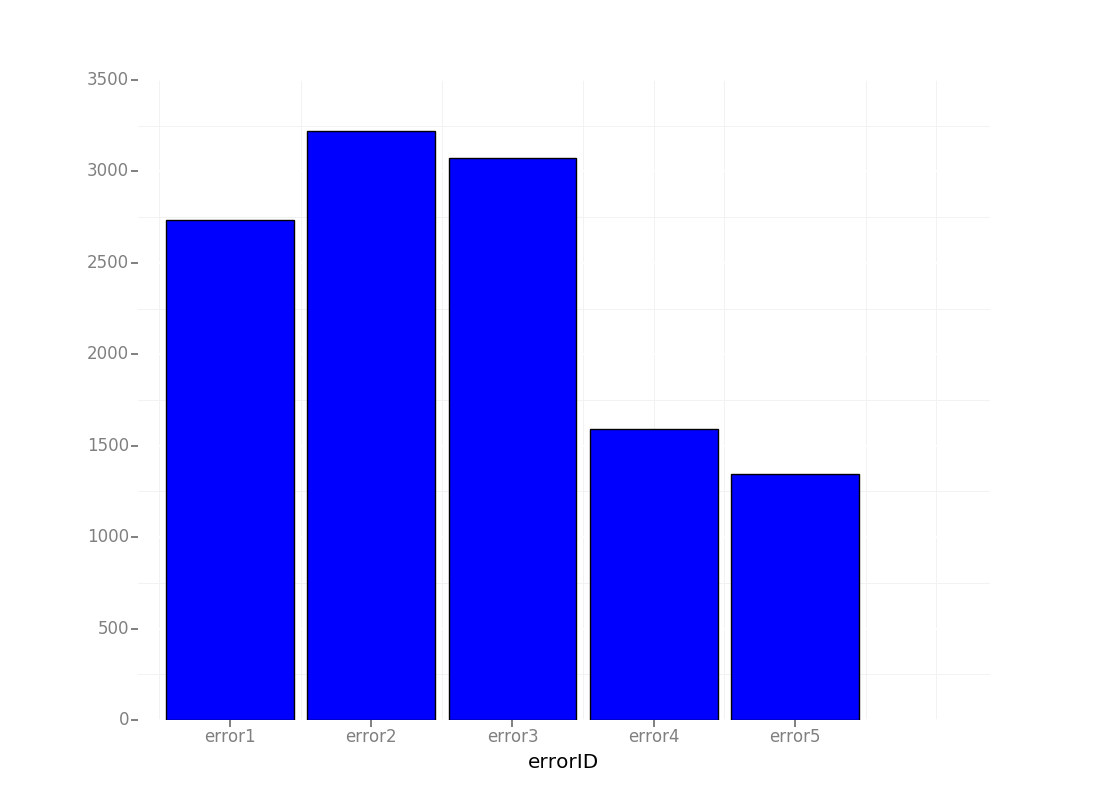

In [8]:
errors = spark.table(ERROR_DATA)

# Quick plot to show structure
pl = ggplot(aes(x="errorID"), errors.toPandas()) + geom_bar(fill="blue", color="black")
display(pl)

The error data consists of a time series (datetime stamped) of error codes thrown by each machine (machineID). The figure shows how many errors occured in each of the five error classes over the entire year. We could split this figure over each individual machine, but with 1000 individuals, the figure would not be very informative.

### Maintenance data set

The maintenance log contains both scheduled and unscheduled maintenance records. Scheduled maintenance corresponds with  regular inspection of components, unscheduled maintenance may arise from mechanical failure or other performance degradations. A failure record is generated for component replacement in the case  of either maintenance events. Because maintenance events can also be used to infer component life, the maintenance data has been collected over two years (2014, 2015) instead of only over the year of interest (2015).

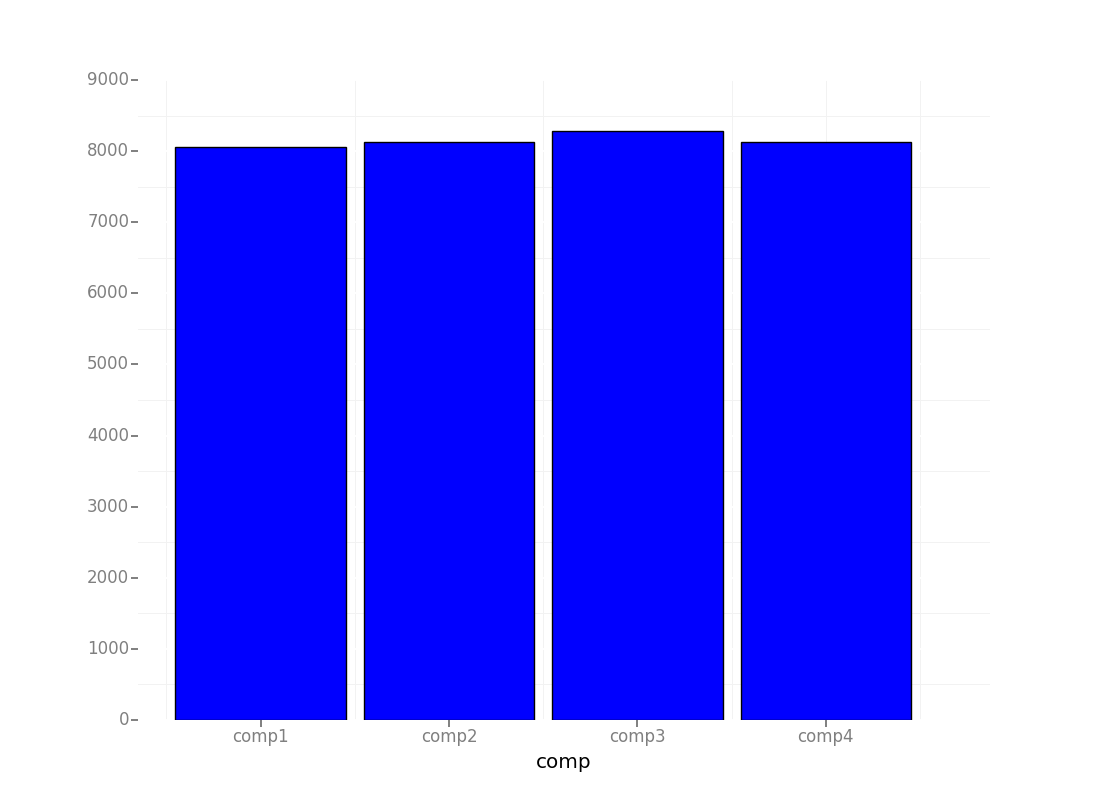

In [11]:
maint = spark.table(MAINT_DATA)

# Quick plot to show structure
pl = ggplot(aes(x="comp"), maint.toPandas()) + geom_bar(fill="blue", color="black")

display(pl)

The figure shows a histogram of component replacements divided into the four component types over the entire maintenance history. It looks like these four components are replaced at similar rates.

There are many ways we might want to look at this data including calculating how long each component type lasts, or the time history of component replacements within each machine. This will take some preprocess of the data, which we are delaying until we do the feature engineering steps in the next example notebook.

Next, we convert the errors data to a Spark dataframe, and verify the data types have converted correctly.

### Telemetry data set

The telemetry time-series data consists of voltage, rotation, pressure, and vibration sensor measurements collected from each  machines in real time. The data is averaged over an hour and stored in the telemetry logs.

Rather than plot 8.7 million data points, this figure plots a month of measurements for a single machine. This is representative of each feature repeated for every machine over the entire year of sensor data collection.

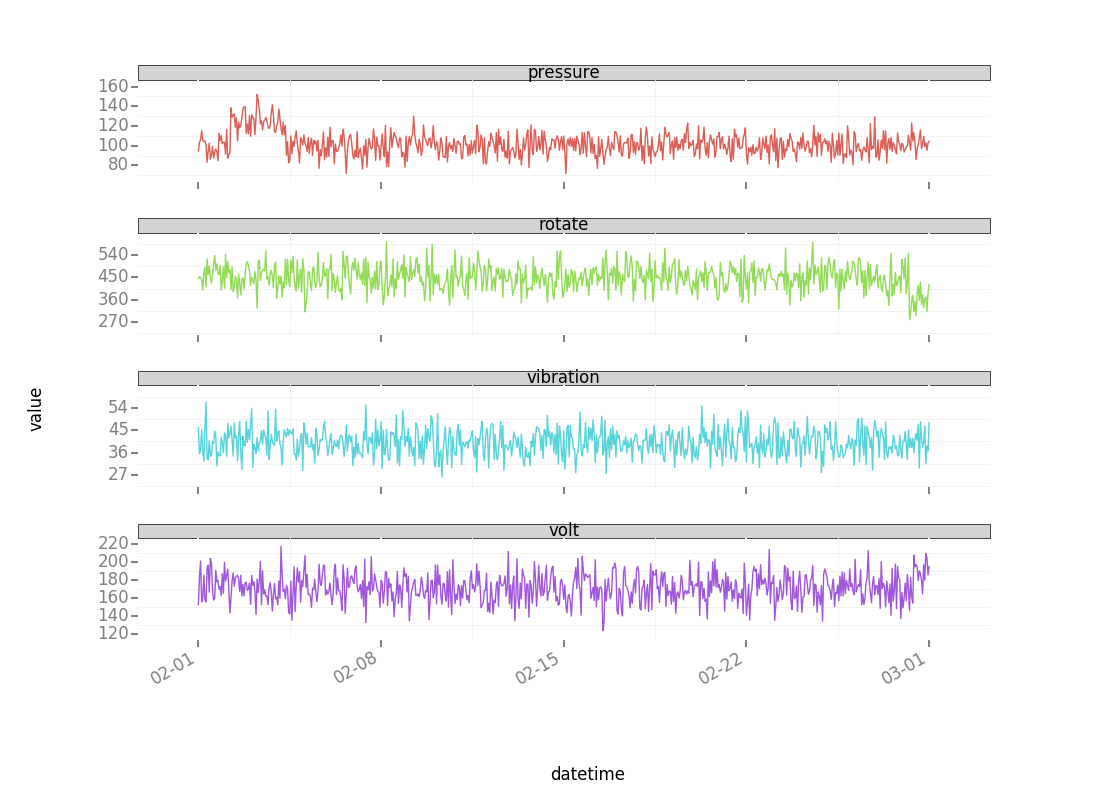

In [15]:
telemetry = spark.table(TELEMETRY_DATA).toPandas()

plt_data = telemetry.loc[telemetry['machineID'] == 1]

# format datetime field which comes in as string
plt_data['datetime'] = pd.to_datetime(plt_data['datetime'], format="%Y-%m-%d %H:%M:%S")


# Quick plot to show structure
plot_df = plt_data.loc[(plt_data['datetime'] >= pd.to_datetime('2015-02-01')) &
                       (plt_data['datetime'] <= pd.to_datetime('2015-03-01'))]

plt_data = pd.melt(plot_df, id_vars=['datetime', 'machineID'])

pl = ggplot(aes(x="datetime", y="value", color = "variable", group="variable"), plt_data) +\
    geom_line() +\
    scale_x_date(labels=date_format('%m-%d')) +\
    facet_grid('variable', scales='free_y')

display(pl)

The figure shows one month worth of telemetry sensor data for one machine. Each sensor is shown in it's own panel.

Next, we convert the errors data to a Spark dataframe, and verify the data types have converted correctly.

### Failures data set

Failures correspond to component replacements within the maintenance log. Each record contains the Machine ID, component type, and replacement datetime. These records will be used to create the machine learning labels we will be trying to predict.

The following histogram details the distribution of the failure records obtained from failure log. This log was built originally from component replacements the maintenance log file.

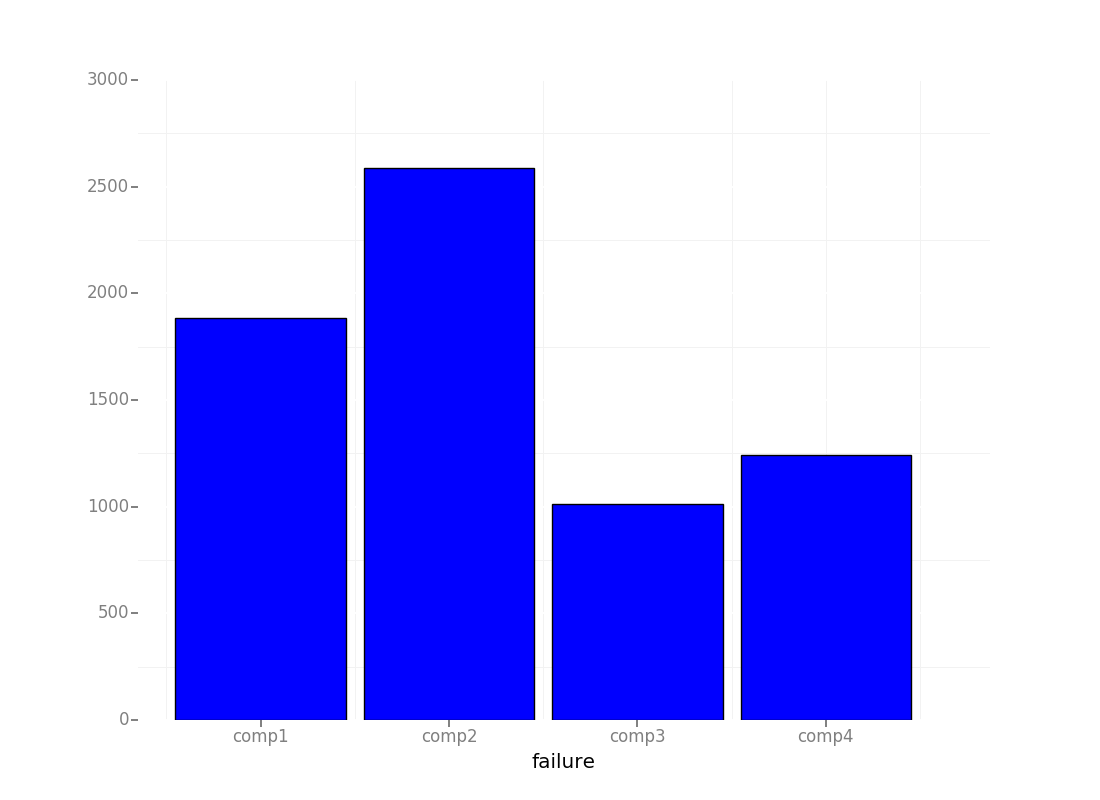

In [18]:
failures = spark.table(FAILURE_DATA)
# Plot failures
pl = ggplot(aes(x="failure"), failures.toPandas()) + geom_bar(fill="blue", color="black")
display(pl)

The figure shows failure related replacements occured for each of the 4 component types over the entire year.

## Conclusion

With these data sets, we next create the manipulate and transform this data into analysis data sets in the `.\notebooks\2a_feature_engineering` Jupyter notebook. This notebook does the feature engineering required for our predictive maintenance machine learning model.